In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun 28 23:16:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.90       Driver Version: 528.90       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   59C    P8    N/A /  N/A |    961MiB /  4096MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
gpu_devices = [device.name for device in local_device_protos if device.device_type == 'GPU']
print(gpu_devices)

['/device:GPU:0']


1. Training set
    - Traing images are original and without "heavy" image processing
    - Imbalanced distribution
    - **Traditional features** from images
        - Local features : SIFT - kmeans (160) + HOG - PCA (160)
        - Texture features: Gabor (96) + LBPH (71)
        - Global (38) + GLCM (16)
2. CNN models
    - Use  full "Transfer Learning" approach with EfficienetB1:
        - Transfer learning 
        - Fine tune the whole CNN
    - Use **Focal Loss** + **class weights in PT**
    - Use basic data augmentation as recommendations of Keras
        - Rotation, translation, shift, shear, ...: Now reduce a little bit the value
    - Use MLP layer for image features: Dense, Batchnorm, Activation Relu, Dropout 0.5
    - Customize ImageDataGenerator 
    - Use Cyclic Learning Rates

In [3]:
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
    print("tensorflow - current version:", tf.__version__)
    print("tensorflow - physical device:", tf.config.list_physical_devices())
else:
    print("The installed version of TensorFlow does not include GPU support.")
    
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
tensorflow - current version: 2.10.1
tensorflow - physical device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import os
import time
import datetime

from pathlib import Path
import pandas as pd


import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Model 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, LeakyReLU,ReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization , Input ,concatenate
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.models import model_from_json
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from collections import Counter
from collections import OrderedDict
from itertools import cycle

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,  roc_curve, auc



import math
import matplotlib.pyplot as plt
from matplotlib import pyplot

import matplotlib.patches as mpatches

from PIL import Image

import random
import numpy as np
from numpy import where

import sys
import importlib.util

import gc
# mixed_precision.set_global_policy('float32')
# policy = mixed_precision.experimental.Policy('float32')
# mixed_precision.experimental.set_policy(policy)

# 1. Mount google drive to access the data and scripts

## 1.2. Unzip the zipped folder to a colab temporary drive

# 1. Load fold1 (training set + validation set) and test set

In [21]:
mycwd = os.getcwd()

display(mycwd)

'c:\\Users\\ldqth\\Workspaces\\RapMed\\_Plankton_Zooscan-Machine_Learning\\_pyscripts\\_transfer_learning'

In [22]:
os.chdir("..")
%pwd

'c:\\Users\\ldqth\\Workspaces\\RapMed\\_Plankton_Zooscan-Machine_Learning\\_pyscripts'

In [23]:
X_train_df = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv')
X_validation_df = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_1.csv')

X_test_df = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [24]:
display(X_train_df.head(5), X_train_df.shape)
display(X_validation_df.head(5), X_validation_df.shape)
display(X_test_df.head(5), X_test_df.shape)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0001-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0003-aggregates.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004.png,0


(44099, 4)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0006-aggregates.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,001-aggregates-jo_700_05.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0010-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0011.png,0


(14700, 4)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,0007-aggregates_002.png,0
1,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,0009-aggregates_001.png,0
2,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,0012-aggregates_002.png,0
3,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,002-aggregates_001.png,0
4,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,002-aggregates_007.png,0


(6907, 4)

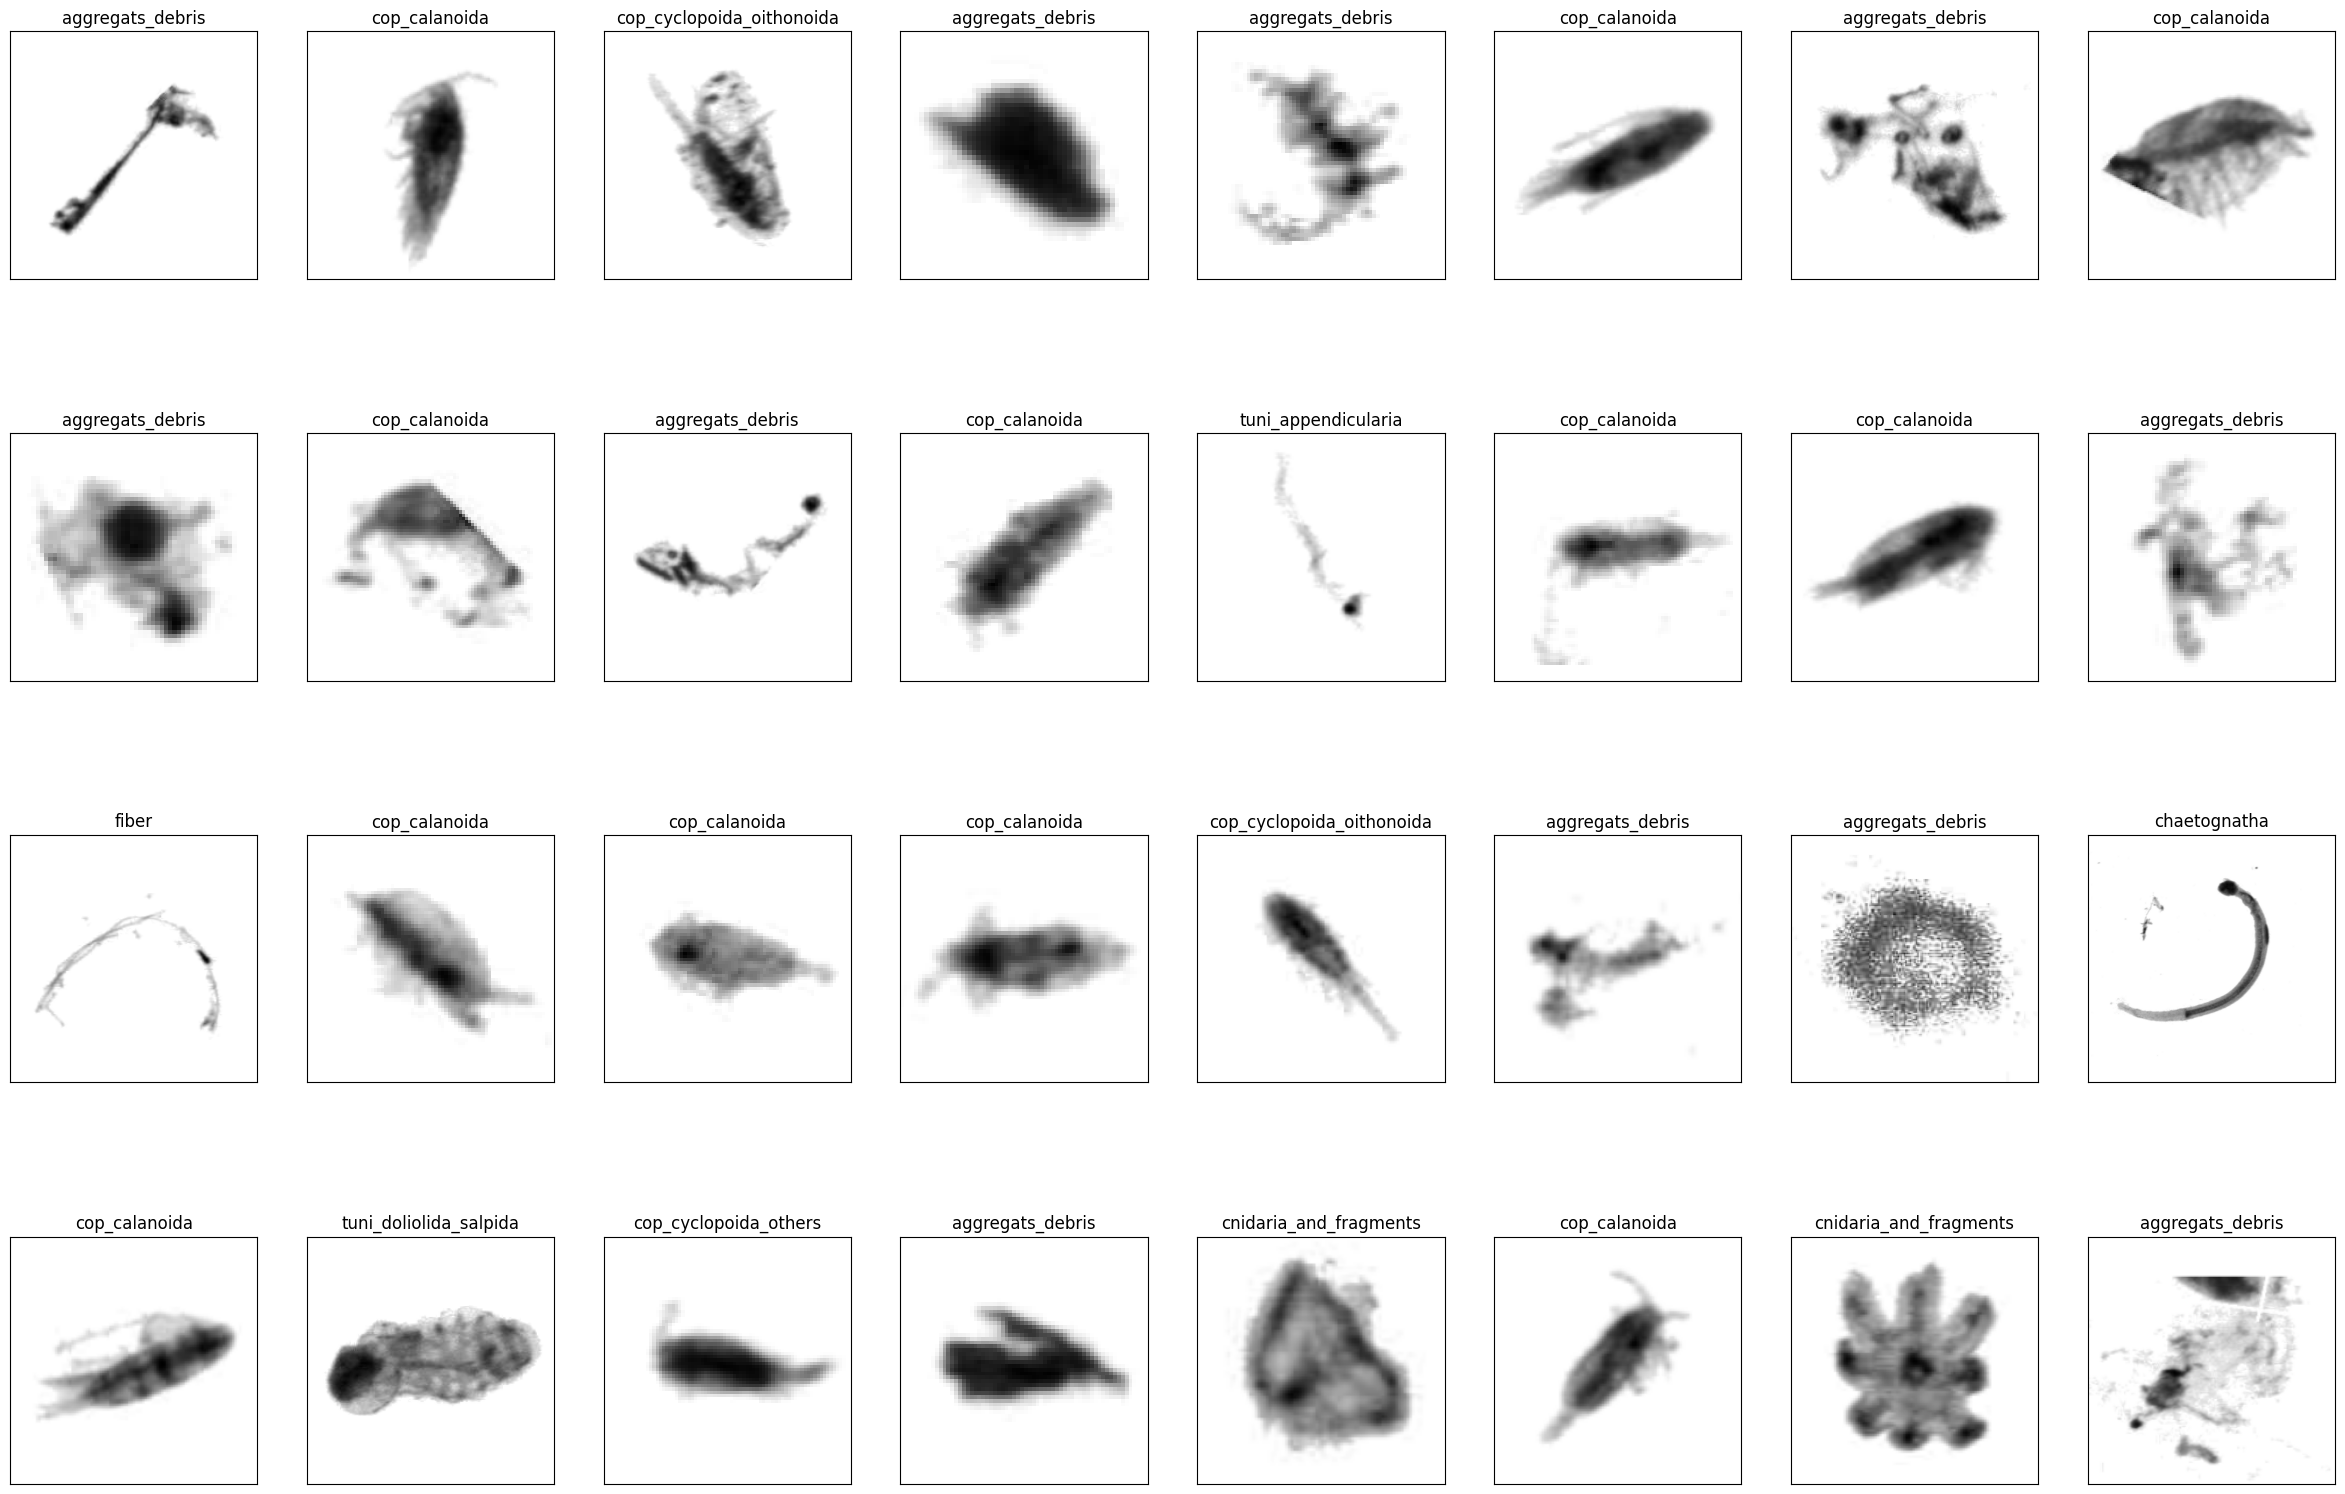

In [25]:
# show some random images in training set

plt.figure(figsize=(30, 20))
for i in range(32):
    row_df = X_train_df.sample()
    label = row_df['labels'].to_list()[0]
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(load_img(row_df['filenames'].to_list()[0], color_mode='rgb', interpolation="nearest"))
    ax.set_title(label)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

# 2. Load image features of fold 1

In [73]:
filepath_SIFT_train = f"..//_inputs//_image_features//new3//X-SIFT_1024_std-train-fold_1.csv"

X_SIFT_train_df = pd.read_csv(filepath_SIFT_train, header=None)

In [74]:
display(X_SIFT_train_df.head(5), X_SIFT_train_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0001-aggregates.png,-0.201468,-0.120201,-0.265277,1.345567,1.404456,-0.223910,-0.153469,-0.299044,0.760385,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,5.407507,-0.153162,-0.131382
1,0002.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,-0.13818,11.354668,10.571298,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382
2,0003-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,0.538241,-0.153469,-0.413064,-0.107453,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382
3,0004-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,1.753329,-0.107453,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382
4,0004.png,-0.201468,5.596114,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382


(44099, 1025)

In [88]:
list(X_SIFT_train_df.iloc[:, 1:].to_numpy())

[array([-0.20146782, -0.12020136, -0.26527717, ...,  5.40750691,
        -0.15316225, -0.13138173]),
 array([-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173]),
 array([-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173]),
 array([-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173]),
 array([-0.20146782,  5.59611432, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173]),
 array([-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173]),
 array([-0.20146782,  2.81219435, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173]),
 array([-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173]),
 array([-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173]),
 array([-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13

In [89]:
result = pd.concat([X_train_df, X_SIFT_train_df], axis=1, join='inner')

In [90]:
display(result.head(5), result.shape)

,filenames,labels,short_filenames,cls,0,1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0001-aggregates.png,0,0001-aggregates.png,-0.201468,-0.120201,-0.265277,1.345567,1.404456,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,5.407507,-0.153162,-0.131382
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002.png,0,0002.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,...,-0.13818,11.354668,10.571298,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0003-aggregates.png,0,0003-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004-aggregates.png,0,0004-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004.png,0,0004.png,-0.201468,5.596114,-0.265277,-0.103267,-0.106819,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382


(44099, 1029)

# 3. Data augmentation function
    - Inputs: 
        - images (dataframe) and feature vector (dataframe)
    - Outputs:
        - a dict {"image":X1, "image_feature":X2}, label of image


In [33]:
from tensorflow.data import AUTOTUNE

In [36]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [99]:
list(X_train_df)

['filenames', 'labels', 'short_filenames', 'cls']

In [98]:
ds = tf.data.Dataset.from_tensor_slices(X_train_df)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [104]:
imagePaths = list(result['filenames'])
imageLabels = list(result['labels'])
imageFeatures = list(result.iloc[:, 5:].to_numpy())

ds = tf.data.Dataset.from_tensor_slices((imagePaths, imageLabels, imageFeatures))


In [106]:
for row in ds.take(3):
  print(row)

(<tf.Tensor: shape=(), dtype=string, numpy=b'..//_inputs//_images_Zooscan//_training//aggregats_debris/0001-aggregates.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'aggregats_debris'>, <tf.Tensor: shape=(1024,), dtype=float64, numpy=
array([-0.20146782, -0.12020136, -0.26527717, ...,  5.40750691,
       -0.15316225, -0.13138173])>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'..//_inputs//_images_Zooscan//_training//aggregats_debris/0002.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'aggregats_debris'>, <tf.Tensor: shape=(1024,), dtype=float64, numpy=
array([-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
       -0.15316225, -0.13138173])>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'..//_inputs//_images_Zooscan//_training//aggregats_debris/0003-aggregates.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'aggregats_debris'>, <tf.Tensor: shape=(1024,), dtype=float64, numpy=
array([-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
       -0.15316225, -0.1313817

In [108]:
def load_images(imagePath, imageLabel, imageFeature):
	# read the image from disk, decode it, convert the data type to
	# floating point, and resize it
	image = tf.io.read_file(imagePath)
	image = tf.io.decode_png(image, channels=1)
	image = tf.image.convert_image_dtype(image, dtype=tf.float32)
	image = tf.image.resize(image, (128, 128))
	
	# return the image and the label
	return (image, imageLabel, imageFeature)

# set the batch size
BATCH_SIZE = 32
# grabs all image paths and their labels
imagePaths = list(result['filenames'])
imageLabels = list(result['labels'])
imageFeatures = list(result.iloc[:, 5:].to_numpy())

print("[INFO] loading the dataset...")
dsTrain = tf.data.Dataset.from_tensor_slices((imagePaths, imageLabels, imageFeatures))
dsTrain = (dsTrain
	.shuffle(len(result), seed=42)
	.map(load_images, num_parallel_calls=AUTOTUNE)
	.cache()
	.batch(BATCH_SIZE)
 	.prefetch(AUTOTUNE)
)

[INFO] loading the dataset...


In [37]:
def load_images(imagePath, imageLabel, imageFeature):
	# read the image from disk, decode it, convert the data type to
	# floating point, and resize it
	image = tf.io.read_file(imagePath)
	image = tf.io.decode_png(image, channels=1)
	image = tf.image.convert_image_dtype(image, dtype=tf.float32)
	image = tf.image.resize(image, (128, 128))
	
	# return the image and the label
	return (image, imageLabel, imageFeature)

In [39]:
# set the batch size
BATCH_SIZE = 32
# grabs all image paths and their labels
imagePaths = list(X_train_df['filenames'])
imageLabels = list(X_train_df['labels'])
imageFeatures = list(X_SIFT_train_df.iloc[:, 1:].to_numpy())
print("[INFO] loading the dataset...")
ds = tf.data.Dataset.from_tensor_slices((imagePaths, imageLabels, imageFeatures))
ds = (ds
	.shuffle(len(imagePaths), seed=42)
	.map(load_images, num_parallel_calls=AUTOTUNE)
	.cache()
	.batch(BATCH_SIZE)
 	.prefetch(AUTOTUNE)
)



[INFO] loading the dataset...


<tf.Tensor: shape=(32, 1024), dtype=float64, numpy=
array([[-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173],
       [-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173],
       [-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173],
       ...,
       [-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173],
       [-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173],
       [-0.20146782, -0.12020136, -0.26527717, ..., -0.10823209,
        -0.15316225, -0.13138173]])>

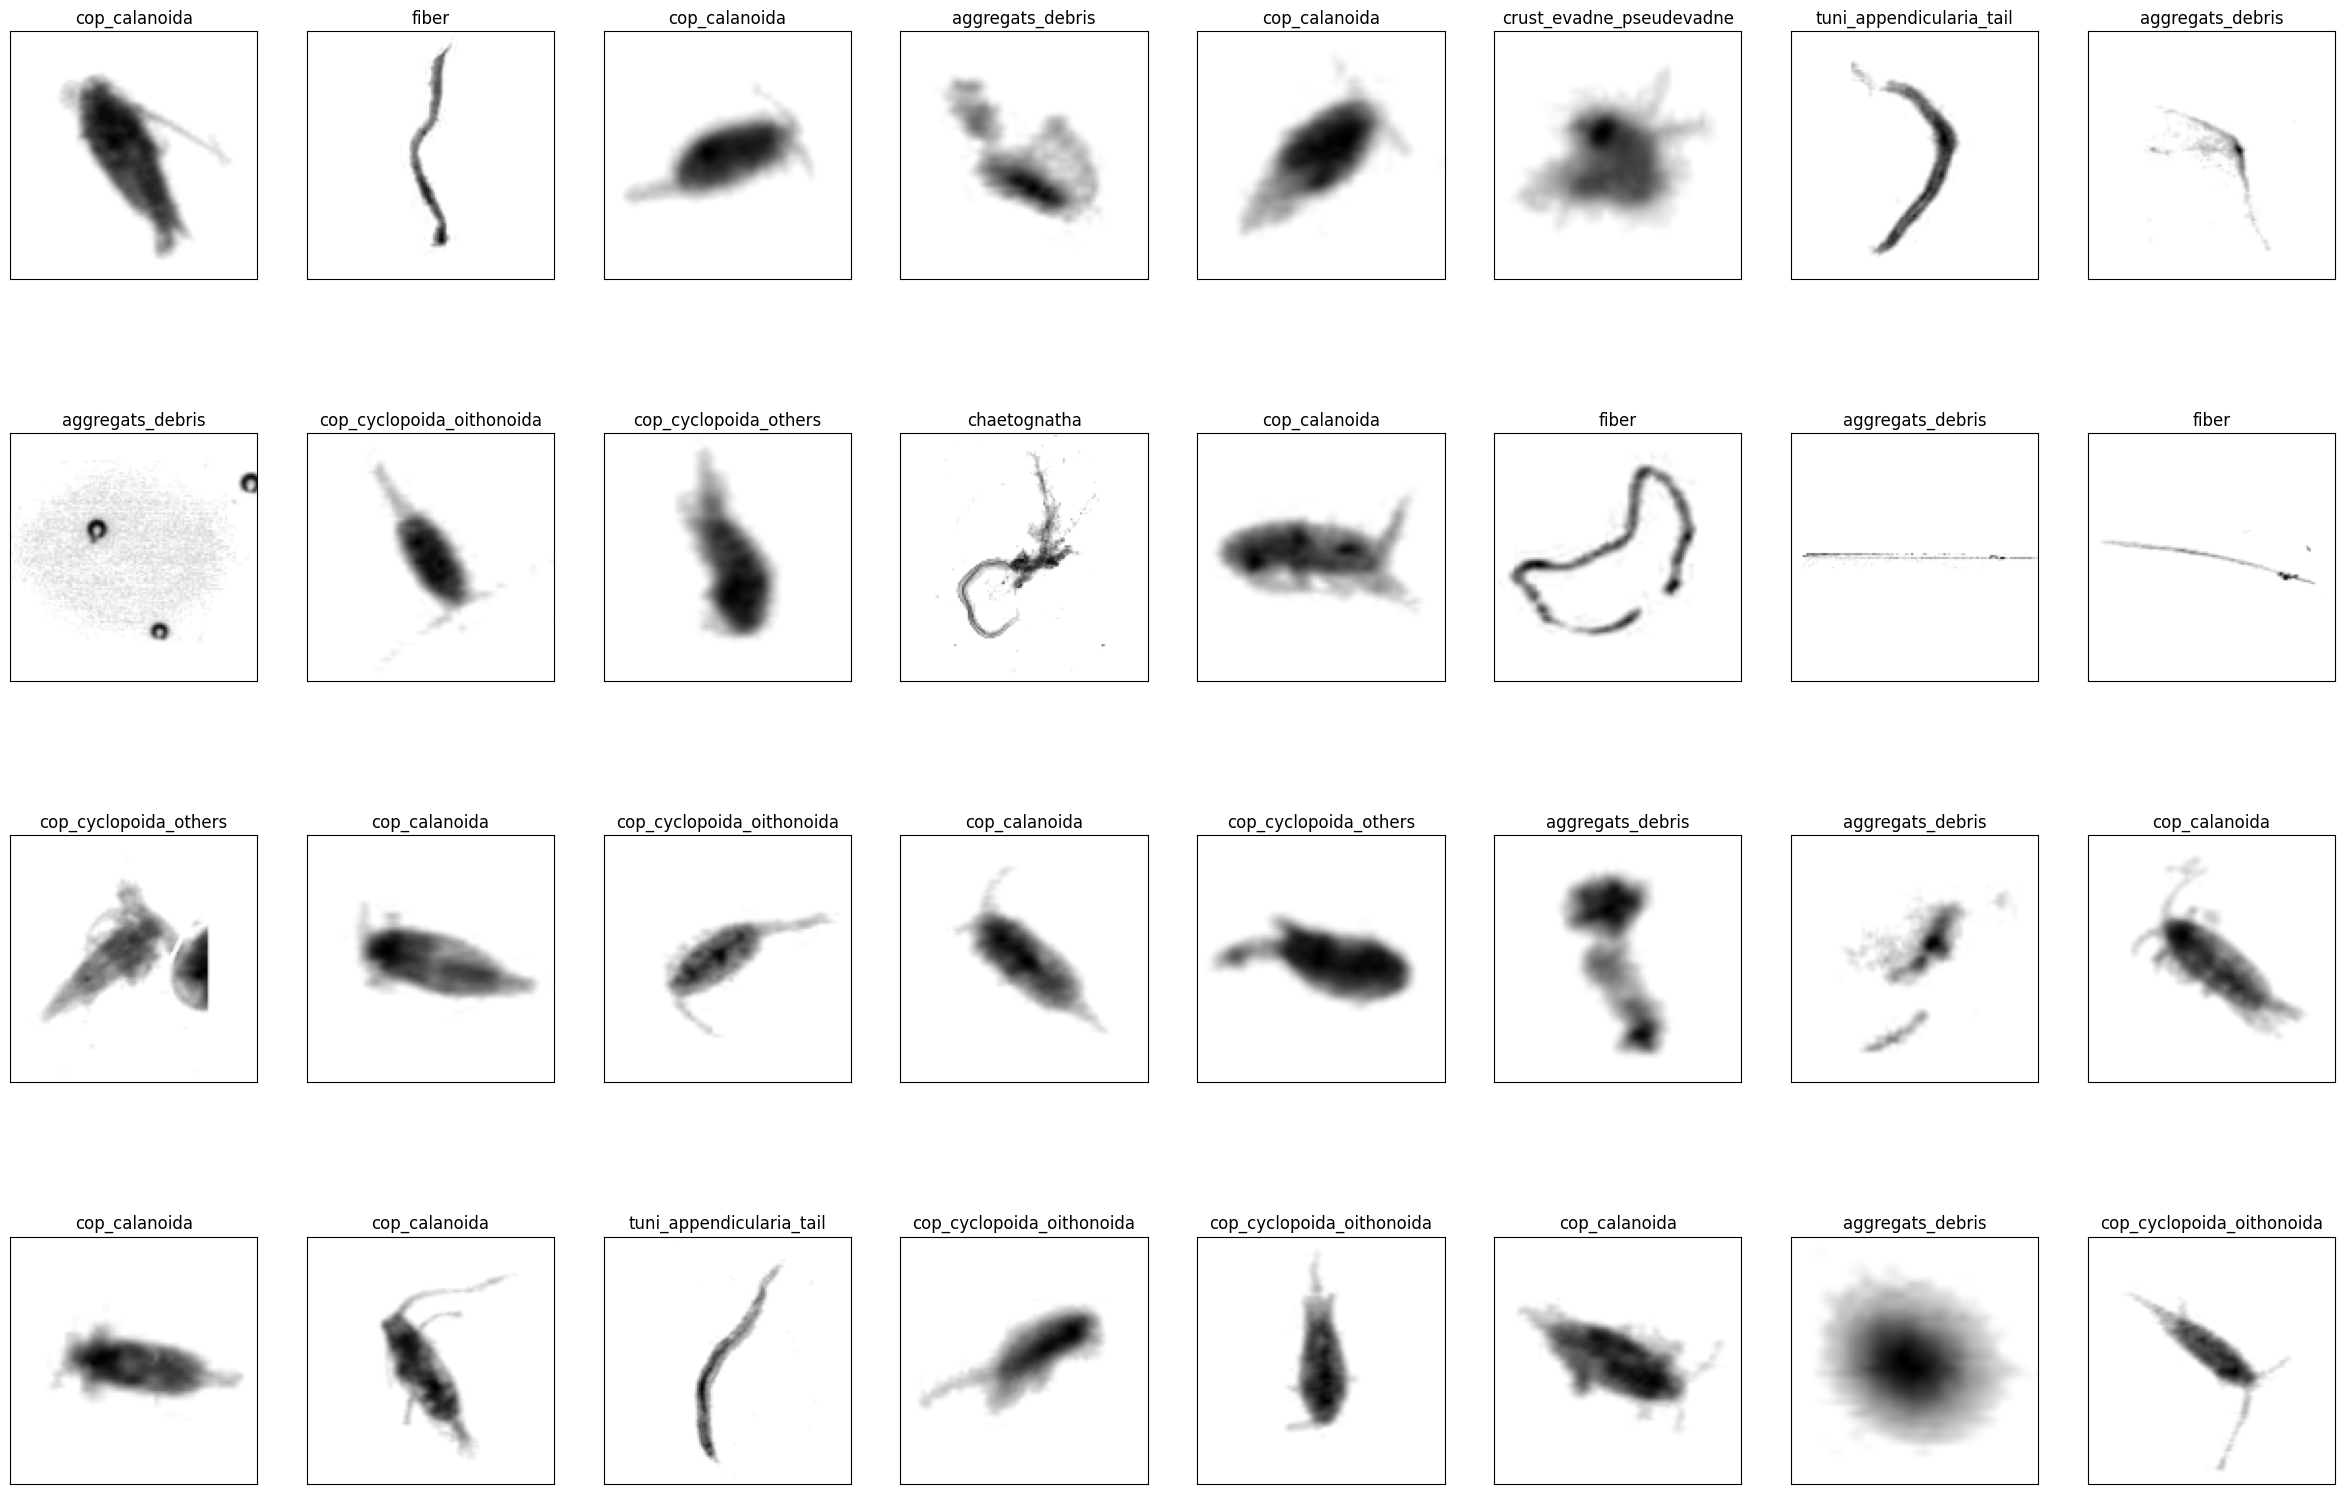

In [111]:
plt.figure(figsize=(30, 20))

for image, label, imgFeat in dsTrain.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(image[i], cmap="gray")
        ax.set_title(label[i].numpy().decode('utf-8'))
        
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

    display(imgFeat)

In [11]:
# Initial settings
IMG_SIZE = (128, 128)
IMG_SHAPE = (*IMG_SIZE, 3)
IMG_TYPE = 'rgb'
BATCH_SIZE = 32
COLOR_MODE = 'rgb'
MAX_EPOCHS = 500

N_CLASSES = 20

In [12]:
train_gen = ImageDataGenerator(
                                dtype = "float32",
                                #rescale = 1./255.0,
                                rotation_range = 360,
                                # width_shift_range=0.2,
                                # height_shift_range=0.2,
                                # brightness_range=[0.4, 1.0],
                                #channel_shift_range=0.2,
                                shear_range=0.1,
                                zoom_range=[0.8, 1.1],
                                horizontal_flip=True,
                                vertical_flip=True,
                                # fill_mode='constant', cval=255,
                                preprocessing_function = preprocess_input
                              )

validation_gen = ImageDataGenerator(
                                    dtype="float32",
                                    preprocessing_function = preprocess_input
                                    #rescale=1./255.0
                                   )


## 3.1. Example for custom imagedatagenerator()

In [13]:

train_iterator = train_gen.flow_from_dataframe(
                                            X_train_df,
                                            x_col = "filenames", y_col = "labels",
                                            batch_size = BATCH_SIZE,
                                            target_size = IMG_SIZE,
                                            color_mode = COLOR_MODE,
                                            class_mode = "categorical", shuffle = True
                                          )

validation_iterator = validation_gen.flow_from_dataframe(
                                                    X_validation_df,
                                                    x_col = "filenames", y_col = "labels",
                                                    batch_size = BATCH_SIZE,
                                                    target_size = IMG_SIZE, 
                                                    color_mode = COLOR_MODE,
                                                    class_mode = "categorical", shuffle = False
                                                       )

Found 1885 validated image filenames belonging to 20 classes.
Found 1886 validated image filenames belonging to 20 classes.


In [14]:
for c1,c2 in zip(train_iterator.class_indices,validation_iterator.class_indices):
    print('{:25}{:30}\t\t{:25}{:30}'.format(c1, train_iterator.class_indices[c1], c2,validation_iterator.class_indices[c2]))

Aggregates_dark                                       0		Aggregates_dark                                       0
Appendicularia                                        1		Appendicularia                                        1
Chaetognatha                                          2		Chaetognatha                                          2
CladoceraPenilia                                      3		CladoceraPenilia                                      3
Copepoda                                              4		Copepoda                                              4
Copepoda_oithona                                      5		Copepoda_oithona                                      5
Copepoda_petit                                        6		Copepoda_petit                                        6
Decapoda_large                                        7		Decapoda_large                                        7
Egg                                                   8		Egg                                    

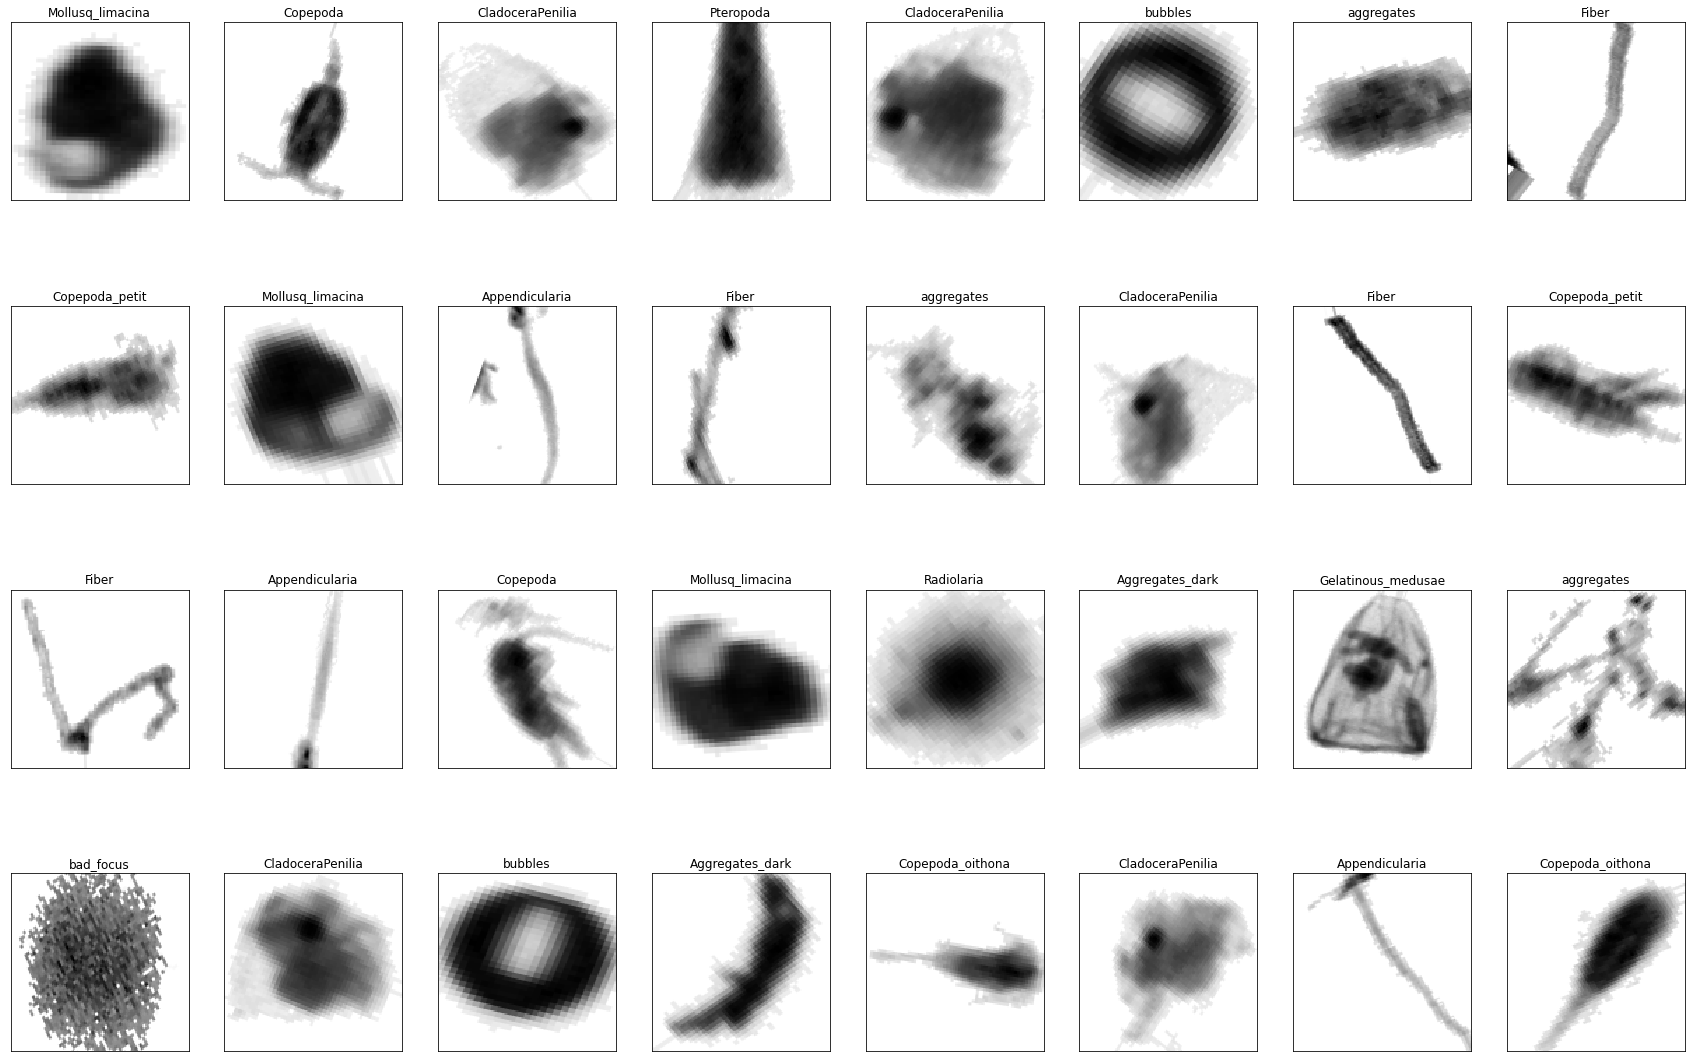

In [15]:
image, y= train_iterator.next()

plt.figure(figsize=(30, 20))
for i in range(image.shape[0]):
    label_value = np.argmax(y[i], axis=0)
    label = list(train_iterator.class_indices.keys())[list(train_iterator.class_indices.values()).index(label_value)]
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(array_to_img(image[i]), interpolation="nearest")
    ax.set_title(label)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    

# 4. Create model CNN + SIFT

## 4.1. Set metrics

In [16]:
# compute class weights
X_TRAINING_df = pd.concat([X_train_df, X_validation_df], ignore_index=True)
classes = X_TRAINING_df.sort_values(by=['labels']).groupby('labels').size().to_frame('number of images').reset_index()
# display(classes)

from scipy.stats.mstats import gmean
count = classes['number of images'].values
# display(count)

weights_PT = gmean(count) / count
#print(weights_PT)

weights_PT[weights_PT < 0.1] = 0.1
weights_PT[weights_PT > 10] = 10
#print(weights_PT)

class_weights_PT = dict(enumerate(weights_PT))
display(class_weights_PT)


{0: 0.7184575230238259,
 1: 0.525881279739089,
 2: 1.7794354930706384,
 3: 0.6539805658293799,
 4: 0.3583874763561473,
 5: 0.5388431422678694,
 6: 0.5222916464302898,
 7: 1.7194545213941002,
 8: 2.186163605772499,
 9: 0.6323613735705574,
 10: 5.465409014431247,
 11: 0.6624738199310602,
 12: 3.0006167138053903,
 13: 0.8949207742928358,
 14: 2.5087123344930315,
 15: 1.7389937773190332,
 16: 0.8012117926914917,
 17: 0.5646917062880993,
 18: 0.5426647248371451,
 19: 0.9109015024052078}

In [17]:
for c1,c2 in zip(class_weights_PT,train_iterator.class_indices):
    print('{:10}{:30}\t\t{:30}{:30}'.format(c1, class_weights_PT[c1], c2,train_iterator.class_indices[c2]))

         0            0.7184575230238259		Aggregates_dark                                            0
         1             0.525881279739089		Appendicularia                                             1
         2            1.7794354930706384		Chaetognatha                                               2
         3            0.6539805658293799		CladoceraPenilia                                           3
         4            0.3583874763561473		Copepoda                                                   4
         5            0.5388431422678694		Copepoda_oithona                                           5
         6            0.5222916464302898		Copepoda_petit                                             6
         7            1.7194545213941002		Decapoda_large                                             7
         8             2.186163605772499		Egg                                                        8
         9            0.6323613735705574		Fiber                          

In [18]:
# set calibration metric, optimization and loss function
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

OPTIMIZER = Adam()
    
LOSS = CategoricalCrossentropy()


## 4.3. Create Network architechture

In [19]:
# create CNN model 

def create_CNN_model(num_classes = N_CLASSES):
    
    # image 
    input_name='image'

    image_input = Input(shape=IMG_SHAPE, name=input_name)
    
    # Create the base model from the pre-trained model MobileNet V2
    pre_trained_model = tf.keras.applications.EfficientNetB1(input_shape=IMG_SHAPE,
                                                   include_top=False,pooling='avg',
                                                   weights='imagenet')

    #freeze the batch normalisation layers
    for layer in reversed(pre_trained_model.layers):
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True
            
    image_network = pre_trained_model(image_input)
    
    image_network = Dropout(0.5)(image_network)   
    
    image_network = layers.Dense(512, activation='relu', name='full_connected_layer')(image_network)
    classfier_layer = Dense(num_classes, activation='softmax', name='classifier')(image_network)
    
    model = Model(
                    inputs=image_input,
                    outputs=classfier_layer
                    )
    return model

In [20]:
model = create_CNN_model(num_classes=N_CLASSES)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

27033600/27018416 [==============================] - 1s 0us/step


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 full_connected_layer (Dense  (None, 512)              655872    
 )                                                               
                                                                 
 classifier (Dense)          (None, 20)                10260     
                                                                 
Total params: 7,241,371
Trainable params: 7,117,268
Non-trainable params: 124,103
_____________________________________________

# 5. Let's train the model

## 5.1. Create path to store all stuffs

Hello! We are working with the CNN model: _Zooscan_3771-EffB1


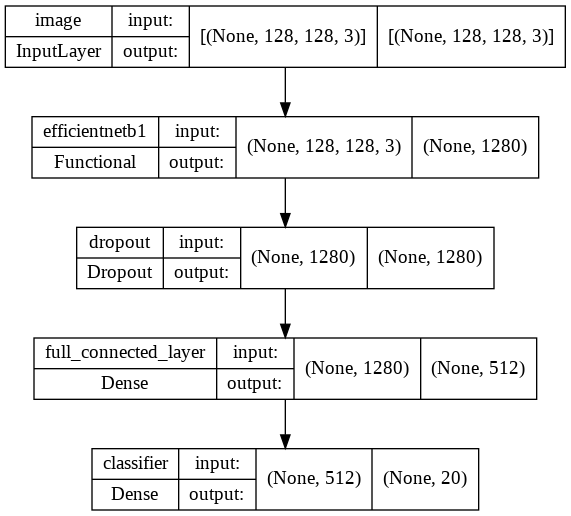

In [22]:
ROOT= f"../gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_outputs"
# ROOT= f"../mytemp"
MODEL_NAME = "_Zooscan_3771-EffB1"

TAGS = "_Zooscan_3771"
index="sec2-WeiPT_final"

print("Hello! We are working with the CNN model:", MODEL_NAME)

# Setup folders

date_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

OUTPUT_DIR = f"{ROOT}"

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    #print("The folder", OUTPUT_DIR, "has been created!")
#else:
#   print("The folder", OUTPUT_DIR, "exists!")

MODEL_DIR = f"{OUTPUT_DIR}//{MODEL_NAME}" 

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    #print("The folder", MODEL_DIR, "has been created!")
#else:
#    print("The folder", MODEL_DIR, "exists!")

LOG_DIR = f"{MODEL_DIR}//_Zooscan-{index}"

if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
#    print("The folder", LOG_DIR, "has been created!")
#else:
#    print("The folder", LOG_DIR, "exists!")

LOGTIME_DIR = f"{LOG_DIR}//_{TAGS}_{date_time}"

if not os.path.exists(LOGTIME_DIR):
    os.mkdir(LOGTIME_DIR)
#    print("The folder", LOGTIME_DIR, "has been created!")
#else:
#    print("The folder", LOGTIME_DIR, "exists!")

CNN_MODEL_NAME = f'{MODEL_NAME}_{date_time}'

# serialize model to JSON (model architechture)
MODEL_ARCHITECHTURE_JSON = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}_model_archJSON.json'
model_json = model.to_json()
with open(MODEL_ARCHITECHTURE_JSON, "w") as json_file:
    json_file.write(model_json)


# serialize weights to HDF5 (model weights)
MODEL_WEIGHTS_INITIAL = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}_model_weights_initial.hdf5'
model.save_weights(MODEL_WEIGHTS_INITIAL)

# save model architecture in image
tf.keras.utils.plot_model(model,f"{LOGTIME_DIR}//_Zooscan_3771-EffB1_weiPT.png", show_shapes=True)

In [23]:
display(MODEL_WEIGHTS_INITIAL)
display(MODEL_ARCHITECHTURE_JSON)

'../gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_outputs//_Zooscan_3771-EffB1//_Zooscan-sec2-WeiPT_final//__Zooscan_3771_20220729-114149//_Zooscan_3771-EffB1_20220729-114149_model_weights_initial.hdf5'

'../gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_outputs//_Zooscan_3771-EffB1//_Zooscan-sec2-WeiPT_final//__Zooscan_3771_20220729-114149//_Zooscan_3771-EffB1_20220729-114149_model_archJSON.json'

In [24]:
!pwd

/content/mytemp


## 5.2. Find the best learning rate bound (i.e., min - max learning rate)

In [24]:
!cp /content/gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_pyscripts/learningRateFinder.py /content/mytemp

In [25]:
path = os.path.abspath('learningRateFinder.py')
print(path)
spec = importlib.util.spec_from_file_location("learningRateFinder", path)
foo4 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo4)
foo4.LRFinder

/content/mytemp/learningRateFinder.py


learningRateFinder.LRFinder

### 5.2.2. Create image loader with custom imagedatagenerator()

In [27]:

train_iterator = train_gen.flow_from_dataframe(
                                            X_train_df,
                                            x_col = "filenames", y_col = "labels",
                                            batch_size = BATCH_SIZE,
                                            target_size = IMG_SIZE,
                                            color_mode = COLOR_MODE,
                                            class_mode = "categorical", shuffle = True
                                          )

validation_iterator = validation_gen.flow_from_dataframe(
                                                    X_validation_df,
                                                    x_col = "filenames", y_col = "labels",
                                                    batch_size = BATCH_SIZE,
                                                    target_size = IMG_SIZE, 
                                                    color_mode = COLOR_MODE,
                                                    class_mode = "categorical", shuffle = False
                                                       )

Found 1885 validated image filenames belonging to 20 classes.
Found 1886 validated image filenames belonging to 20 classes.


### 5.2.3. Load and run initial CNN model

In [28]:
del model
K.clear_session()
gc.collect()

3114

In [29]:
# load initial CNN model 

json_file = open(MODEL_ARCHITECHTURE_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# set calibration metric, optimization and loss function
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
            ]

OPTIMIZER = Adam()
    
LOSS = CategoricalCrossentropy()

model.load_weights(MODEL_WEIGHTS_INITIAL)


model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [30]:
lr_finder = foo4.LRFinder(model)
lr_finder.find(train_iterator,
               validation_iterator, 
               start_lr=1e-10, end_lr=1e-2, 
               class_weight = class_weights_PT,
               epochs=5)

Epoch 1/5
59/59 [==============================] - 42s 245ms/step - loss: 2.6036 - accuracy: 0.0456 - prc: 0.0512 - val_loss: 3.0684 - val_accuracy: 0.0387 - val_prc: 0.0524
Epoch 2/5
59/59 [==============================] - 12s 201ms/step - loss: 2.6513 - accuracy: 0.0408 - prc: 0.0481 - val_loss: 3.0672 - val_accuracy: 0.0387 - val_prc: 0.0525
Epoch 3/5
59/59 [==============================] - 12s 206ms/step - loss: 2.6334 - accuracy: 0.0472 - prc: 0.0504 - val_loss: 3.0203 - val_accuracy: 0.0440 - val_prc: 0.0568
Epoch 4/5
59/59 [==============================] - 13s 226ms/step - loss: 2.3352 - accuracy: 0.1241 - prc: 0.1085 - val_loss: 1.8482 - val_accuracy: 0.5318 - val_prc: 0.5501
Epoch 5/5
59/59 [==============================] - 10s 160ms/step - loss: 123.3146 - accuracy: 0.3176 - prc: 0.2480 - val_loss: 5593.1909 - val_accuracy: 0.1018 - val_prc: 0.0606


1.3570019006729126
238
0.0002846017


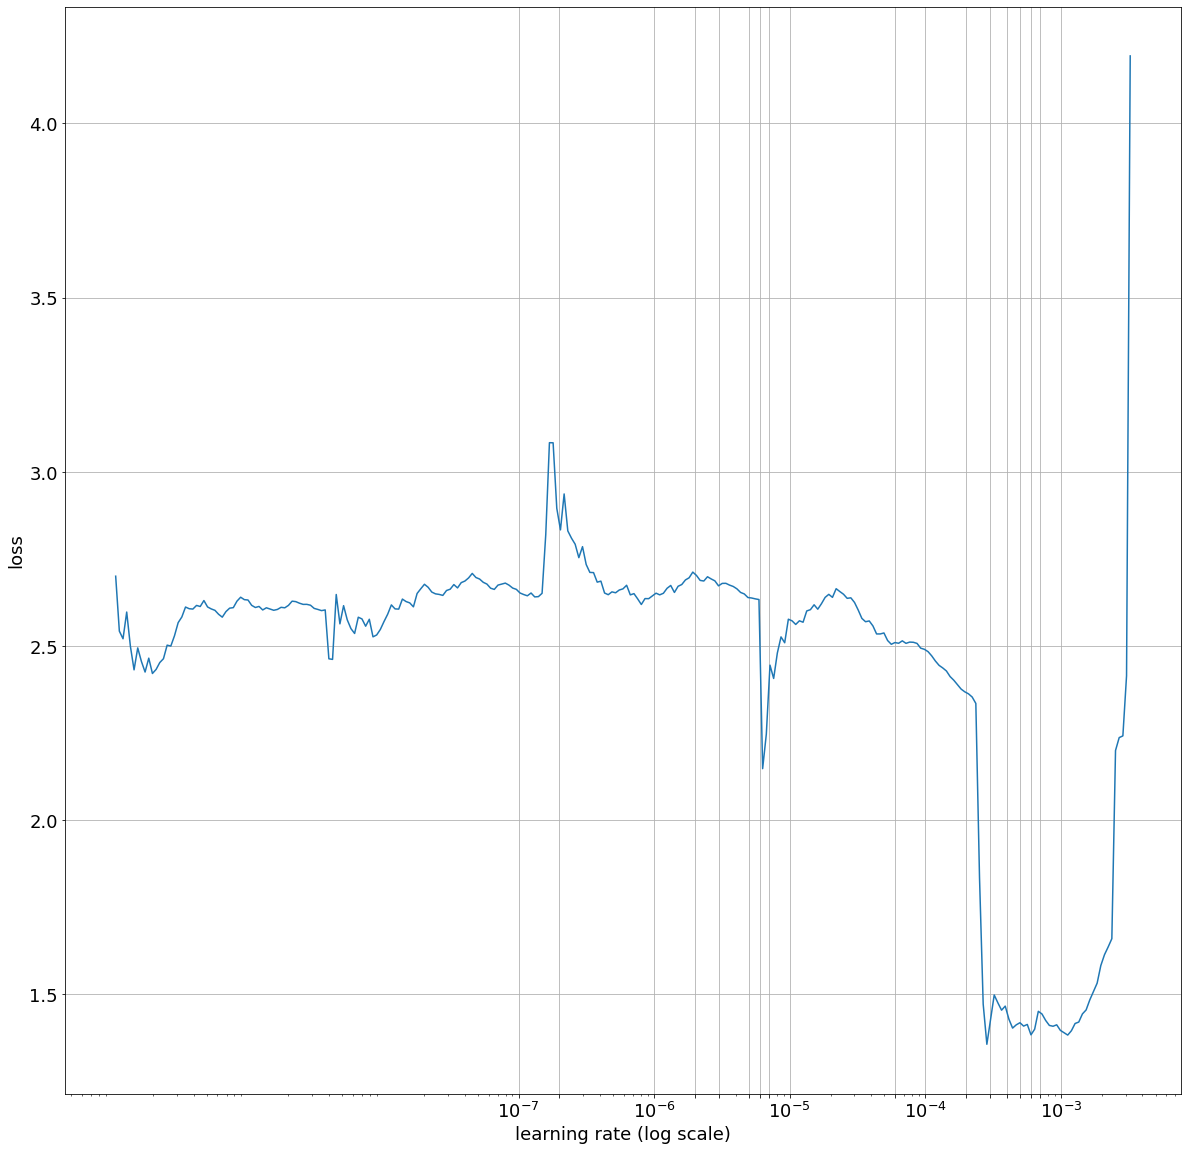

In [31]:
#final
min_value = min(lr_finder.losses)
print(min_value)
min_index = lr_finder.losses.index(min_value)
print(min_index)
print(lr_finder.lrs[min_index]) 


fig = plt.figure()
fig.set_size_inches(20,20, forward=True)
plt.rc('font', size=18)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)

# ax = fig.gca()

plt.xticks([1e-7,2e-7,1e-6,2e-6,3e-6,5e-6,6e-6, 7e-6,1e-5, 6e-5,1e-4,2e-4,3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 1e-3])
# 
# plt.xticks([1e-7, 1.7e-7])
plt.show()

1.0786864757537842
237
0.0002673738


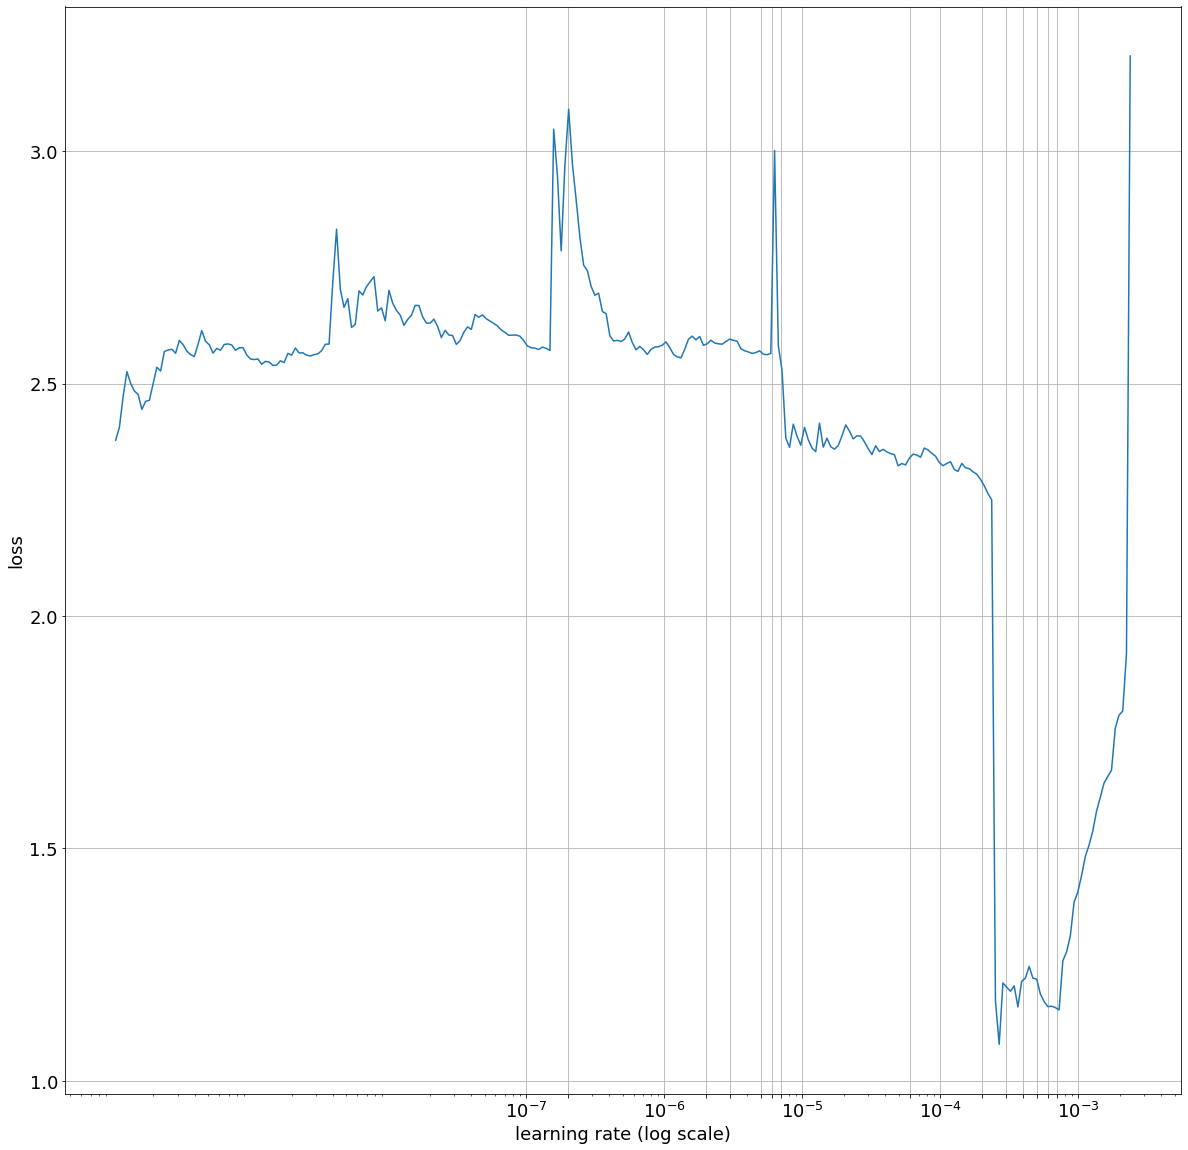

In [ ]:
#final
min_value = min(lr_finder.losses)
print(min_value)
min_index = lr_finder.losses.index(min_value)
print(min_index)
print(lr_finder.lrs[min_index]) 


fig = plt.figure()
fig.set_size_inches(20,20, forward=True)
plt.rc('font', size=18)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)

# ax = fig.gca()

plt.xticks([1e-7,2e-7,1e-6,2e-6,3e-6,5e-6,6e-6, 7e-6,1e-5, 6e-5,1e-4,2e-4,3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 1e-3])
# 
# plt.xticks([1e-7, 1.7e-7])
plt.show()

### **5.3. Run the model**

In [25]:
!pwd

/content/mytemp


In [26]:
LOGTIME_DIR

'../gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_outputs//_Zooscan_3771-EffB1//_Zooscan-sec2-WeiPT_final//__Zooscan_3771_20220729-114149'

In [27]:
%%writefile {LOGTIME_DIR}/training_configuration.txt

train_gen = ImageDataGenerator(
                                dtype = "float32",
                                #rescale = 1./255.0,
                                rotation_range = 360,
                                # width_shift_range=0.2,
                                # height_shift_range=0.2,
                                # brightness_range=[0.4, 1.0],
                                #channel_shift_range=0.2,
                                shear_range=0.1,
                                zoom_range=[0.8, 1.1],
                                horizontal_flip=True,
                                vertical_flip=True,
                                # fill_mode='constant', cval=255,
                                preprocessing_function = preprocess_input
                              )
                              

# create CNN model 

def create_CNN_model(num_classes = N_CLASSES):
    
    # image 
    input_name='image'

    image_input = Input(shape=IMG_SHAPE, name=input_name)
    
    # Create the base model from the pre-trained model MobileNet V2
    pre_trained_model = tf.keras.applications.EfficientNetB1(input_shape=IMG_SHAPE,
                                                   include_top=False,pooling='avg',
                                                   weights='imagenet')

    #freeze the batch normalisation layers
    for layer in reversed(pre_trained_model.layers):
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True
            
    image_network = pre_trained_model(image_input)
    
    image_network = Dropout(0.5)(image_network)   
    
    image_network = layers.Dense(512, activation='relu', name='full_connected_layer')(image_network)
    classfier_layer = Dense(num_classes, activation='softmax', name='classifier')(image_network)
    
    model = Model(
                    inputs=image_input,
                    outputs=classfier_layer
                    )
    return model

def create_Callbakcs(strBestModelName, steps_per_epoch):

    min_learningRate = 1e-4 # minimum learning rate or initial learning rate
    max_learningRate = 3e-4  # maximum learning rate
    
    clr_triangular = foo3.CyclicLR(base_lr=min_learningRate, max_lr=max_learningRate,step_size=8*steps_per_epoch, mode='triangular2')

    early_stopping = EarlyStopping(patience=20, monitor='val_prc', min_delta=0.001, verbose=1, mode='max') # calibration metric = "val+prc"
    model_checkpoint = ModelCheckpoint(strBestModelName, monitor="val_prc", save_best_only=True, verbose=1, mode='max')
    
    return [clr_triangular, early_stopping, model_checkpoint]

Writing ../gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_outputs//_Zooscan_3771-EffB1//_Zooscan-sec2-WeiPT_final//__Zooscan_3771_20220729-114149/training_configuration.txt


In [36]:
!cp /content/gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_pyscripts/CyclicLR.py /content/mytemp

In [37]:
path = os.path.abspath('CyclicLR.py')
print(path)
spec = importlib.util.spec_from_file_location("CyclicLR", path)
foo3 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo3)
foo3.CyclicLR

del train_iterator, validation_iterator

def create_Callbakcs(strBestModelName, steps_per_epoch):

    min_learningRate = 1e-4 # minimum learning rate or initial learning rate
    max_learningRate = 3e-4  # maximum learning rate
    
    clr_triangular = foo3.CyclicLR(base_lr=min_learningRate, max_lr=max_learningRate,step_size=8*steps_per_epoch, mode='triangular2')

    early_stopping = EarlyStopping(patience=20, monitor='val_prc', min_delta=0.001, verbose=1, mode='max') # calibration metric = "val+prc"
    model_checkpoint = ModelCheckpoint(strBestModelName, monitor="val_prc", save_best_only=True, verbose=1, mode='max')
    
    return [clr_triangular, early_stopping, model_checkpoint]

/content/mytemp/CyclicLR.py


In [38]:
all_history={}

fold='man1'


train_iterator = train_gen.flow_from_dataframe(
                                            X_train_df,
                                            x_col = "filenames", y_col = "labels",
                                            batch_size = BATCH_SIZE,
                                            target_size = IMG_SIZE,
                                            color_mode = COLOR_MODE,
                                            class_mode = "categorical", shuffle = True
                                          )

validation_iterator = validation_gen.flow_from_dataframe(
                                                    X_validation_df,
                                                    x_col = "filenames", y_col = "labels",
                                                    batch_size = BATCH_SIZE,
                                                    target_size = IMG_SIZE, 
                                                    color_mode = COLOR_MODE,
                                                    class_mode = "categorical", shuffle = False
                                                       )




print("... Working at fold ", fold, "...")
steps_per_epoch = train_iterator.__len__()
print("\t step per epoch is: ", steps_per_epoch)


# load initial model
json_file = open(MODEL_ARCHITECHTURE_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

LOSS = CategoricalCrossentropy()

OPTIMIZER = Adam(learning_rate=1e-04)

METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

print("\t 1. Reloading initial weights of the CNN model...")
model.load_weights(MODEL_WEIGHTS_INITIAL)

print("\t 1.1. Re-compiling the CNN model...")
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

print("\t 2. Starting training the model...")
start = time.time()

MODEL_CHECKPOINTS = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'


myCallbacks = create_Callbakcs(strBestModelName=MODEL_CHECKPOINTS, steps_per_epoch=steps_per_epoch)

print("\t\t 2.1. Best model will be stored in the file: ", MODEL_CHECKPOINTS)

history_TLearning = model.fit(
                                train_iterator, 
                                validation_data = validation_iterator, 
                                epochs = MAX_EPOCHS,
                                callbacks=myCallbacks, 
                                class_weight = class_weights_PT,
                                verbose=0
                                )

time_done = time.time() - start

print("\t\t 2.2. Total time for training the CNN model in fold ", fold, "is: ", time_done, "seconds")

MODEL_TIME = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-TrainingTime-fold_{fold}.txt'
with open(MODEL_TIME, mode='w') as file:
    file.write('Total time for training the CNN model: %3f seconds.\n' %time_done)


MODEL_WEIGHTS_FINAL = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-model_weights_final-fold_{fold}.hdf5'
print("\t\t 2.3. Model at final epoch will be stored in the file: ", MODEL_WEIGHTS_FINAL)
model.save_weights(MODEL_WEIGHTS_FINAL)


#save whole model at final epoch of training process
MODEL_FINAL_EPOCH = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-model_final_epoch-fold_{fold}.hdf5'
print("\t\t 2.4. Model's weights at final epoch will be stored in the folder: ", MODEL_FINAL_EPOCH)
model.save(MODEL_FINAL_EPOCH)

# convert the history.history dict to a pandas DataFrame
# Save the history to CSV for further visualization
hist_df = pd.DataFrame(history_TLearning.history.copy()) 

HISTORY_CSV = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-History-fold_{fold}.csv'
print("\t\t 2.5. Learning curve of the model will be stored in the file: ", HISTORY_CSV)

with open(HISTORY_CSV, mode='w') as f:
    hist_df.to_csv(f)

print("... Ended fold ", fold, "...\n\n")

all_history[f'history-fold-{fold}'] = history_TLearning
    

Found 1885 validated image filenames belonging to 20 classes.
Found 1886 validated image filenames belonging to 20 classes.
... Working at fold  man1 ...
	 step per epoch is:  59
	 1. Reloading initial weights of the CNN model...
	 1.1. Re-compiling the CNN model...
	 2. Starting training the model...
		 2.1. Best model will be stored in the file:  ../gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_outputs//_Zooscan_3771-EffB1//_Zooscan-sec2-WeiPT_final//__Zooscan_3771_20220729-114149//_Zooscan_3771-EffB1_20220729-114149-best_model-fold_man1.hdf5

Epoch 1: val_prc improved from -inf to 0.64765, saving model to ../gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_outputs//_Zooscan_3771-EffB1//_Zooscan-sec2-WeiPT_final//__Zooscan_3771_20220729-114149/_Zooscan_3771-EffB1_20220729-114149-best_model-fold_man1.hdf5

Epoch 2: val_prc improved from 0.64765 to 0.84405, saving model to ../gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_outputs//_Zooscan_3771-EffB1/

### 5.4. Plot the accuracy and validation curve

In [39]:
!cp /content/gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_pyscripts/plot_result.py /content/mytemp

In [40]:
path = os.path.abspath('plot_result.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_result", path)
foo2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo2)
foo2.plot_result

/content/mytemp/plot_result.py


<function plot_result.plot_result>

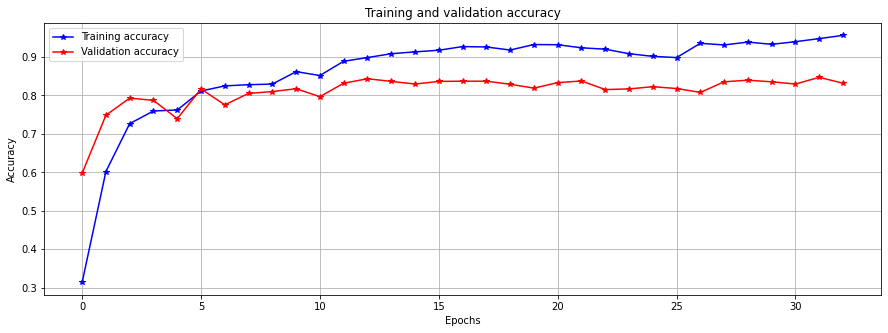

<Figure size 432x288 with 0 Axes>

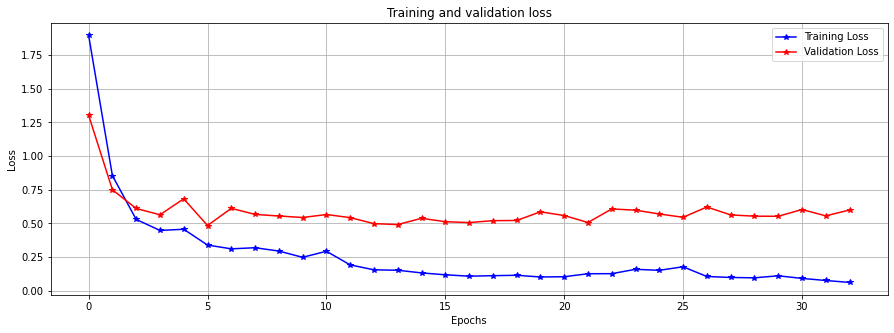

<Figure size 432x288 with 0 Axes>

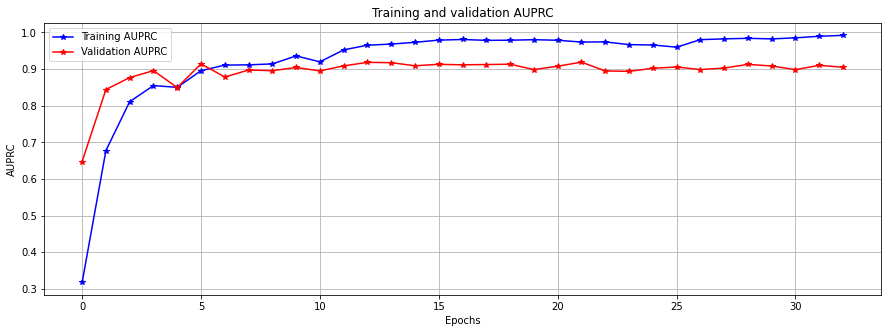

<Figure size 432x288 with 0 Axes>

In [41]:
foo2.plot_result(LOGTIME_DIR, all_history) 

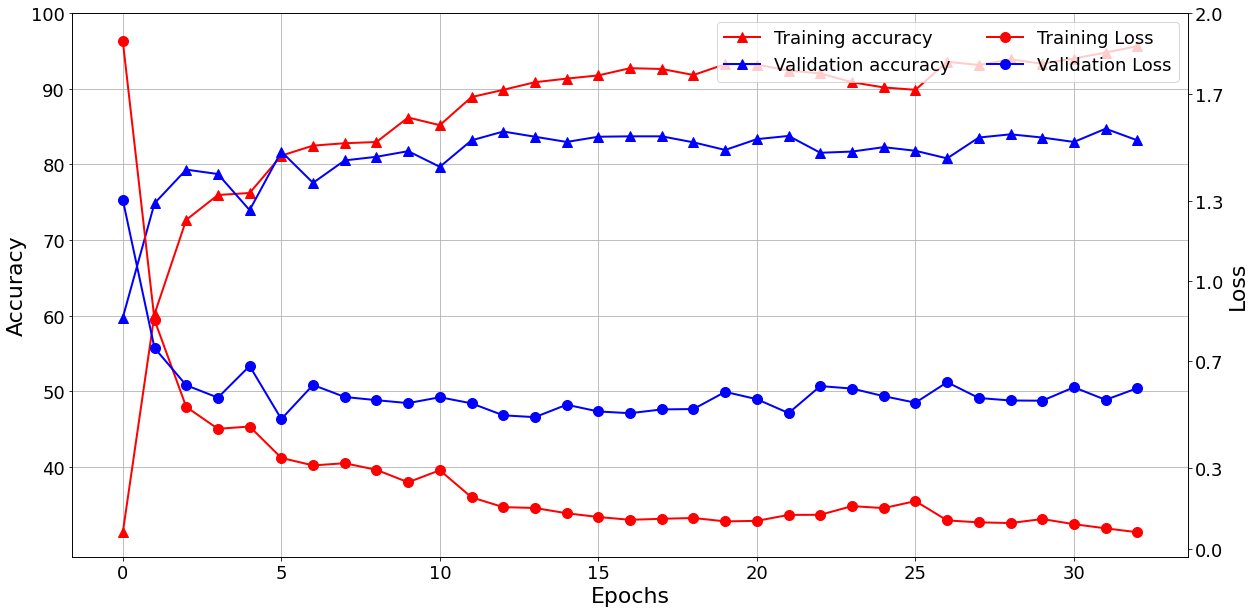

In [42]:
for index, history in enumerate(all_history):
        acc = np.array(all_history[history].history['accuracy'].copy())*100
        val_acc = np.array(all_history[history].history['val_accuracy'].copy())*100
        loss = all_history[history].history['loss'].copy()
        val_loss = all_history[history].history['val_loss'].copy()
        epochs = range(len(acc))

        # plt.figure(figsize=(15, 5))
        # plt.plot(epochs, acc, 'b*-', label='Training accuracy')
        # plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
        # plt.grid()
        # plt.title('Training and validation accuracy')
        # plt.ylabel("Accuracy")
        # plt.xlabel("Epochs")
        # plt.legend()
        # # plt.savefig(f'{folder}/fold-{index+1}-acc.png')
        # plt.figure()
        # plt.show()
        
        markersize=10
        linewidth=2
        fontsize=22
        
        # create figure and axis objects with subplots()
        fig, ax1 = plt.subplots(figsize=(20, 10))
        # make a plot
        p1, = ax1.plot(epochs, acc, 'r^-', linewidth=linewidth, markersize=markersize, label='Training accuracy')
        p2, = ax1.plot(epochs, val_acc, 'b^-', linewidth=linewidth, markersize=markersize, label='Validation accuracy')
        # set x-axis label
        ax1.set_xlabel("Epochs",fontsize=fontsize)
        # set y-axis label
        ax1.set_ylabel("Accuracy",fontsize=fontsize)
        # ax.set_ylim([0, 100])
        
        # twin object for two different y-axis on the sample plot
        ax2 = ax1.twinx()
        # make a plot with different y-axis using second axis object
        p3, = ax2.plot(epochs, loss, 'ro-', linewidth=linewidth, markersize=markersize, label='Training Loss')
        p4, = ax2.plot(epochs, val_loss, 'bo-', linewidth=linewidth, markersize=markersize, label='Validation Loss')
        
        ax2.set_ylabel("Loss",fontsize=fontsize) 
        # ax2.set_ylim([0, 2])
        
        ax1.set_yticks(np.linspace(40, 100, 7))
        ax2.set_yticks(np.round(np.linspace(0, 2, 7),1))

        ax1.grid(), 
        # ax2.grid()
        # ax.legend()
        plt.legend(ncol=2, handles=[p1, p2,p3,p4],fontsize=fontsize-4)
        
        ax1.tick_params(axis='x', labelsize=fontsize-4)
        ax1.tick_params(axis='y', labelsize=fontsize-4)
        
        ax2.tick_params(axis='y', labelsize=fontsize-4)
        
#         for tick in ax1.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
#         for tick in ax2.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
                
#         for tick in ax1.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
#         for tick in ax2.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
                
        plt.show()
        
        # save the plot as a file
        fig.savefig(f'{LOGTIME_DIR}/fold-{index+1}-accuracy_loss.jpg',
                    format='jpeg',
                    dpi=600,
                    bbox_inches='tight')

#         plt.figure(figsize=(15, 5))
#         loss = all_history[history].history['loss'].copy()
#         val_loss = all_history[history].history['val_loss'].copy()
#         plt.plot(epochs, loss, 'b*-', label='Training Loss')
#         plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
#         plt.grid()
#         plt.title('Training and validation loss')
#         plt.ylabel("Loss")
#         plt.xlabel("Epochs")
#         plt.legend()
#         plt.savefig(f'{folder}/fold-{index+1}-loss.png')
#         plt.figure()
#         plt.show()
        
#         plt.figure(figsize=(15, 5))
#         prc = all_history[history].history['prc'].copy()
#         val_prc = all_history[history].history['val_prc'].copy()
#         plt.plot(epochs, prc, 'b*-', label='Training AUPRC')
#         plt.plot(epochs, val_prc, 'r*-', label='Validation AUPRC')
#         plt.grid()
#         plt.title('Training and validation AUPRC')
#         plt.ylabel("AUPRC")
#         plt.xlabel("Epochs")
#         plt.legend()
#         plt.savefig(f'{folder}/fold-{index+1}-AUPRC.png')
#         plt.figure()
#         plt.show()

# 6. Evaluate model

In [43]:
!cp /content/gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_pyscripts/plotConfusionMatrix.py /content/mytemp

In [44]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

path = os.path.abspath('plotConfusionMatrix.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_confusion_matrix", path)
foo5 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo5)
foo5.plot_confusion_matrix

from sklearn.metrics import balanced_accuracy_score, jaccard_score, average_precision_score, accuracy_score, recall_score

def calc_ClassBalancedAccuracy(confusion_matrix, classes_values, class_names): 
    result=0
    class_number = len(class_names)
    for i in classes_values:
        result += confusion_matrix[i][i] / max(sum(confusion_matrix[i,0:]), sum(confusion_matrix[0:,i]))

    result /= class_number
    
    return result


def computeGeometricAverageOfRecall(test_true, test_pred):
    result = 1.0
    for label in np.unique(test_true):
        idx = (test_true==label)
        result *= accuracy_score(np.array(test_true)[idx],np.array(test_pred)[idx])

    result = np.power(result, 1/len(np.unique(test_true)))

    return result


# display(MODEL_CHECKPOINTS)

display(LOGTIME_DIR)

display(CNN_MODEL_NAME)

/content/mytemp/plotConfusionMatrix.py


'../gdrive/MyDrive/_Colab_Notebooks/_Zooscan-CENTER_NOProcess/_outputs//_Zooscan_3771-EffB1//_Zooscan-sec2-WeiPT_final//__Zooscan_3771_20220729-114149'

'_Zooscan_3771-EffB1_20220729-114149'

Found 1886 validated image filenames belonging to 20 classes.
Counter({4: 214, 6: 147, 1: 146, 5: 142, 18: 141, 17: 136, 9: 121, 3: 117, 11: 116, 0: 107, 16: 95, 13: 85, 19: 84, 7: 44, 15: 44, 2: 43, 8: 35, 14: 30, 12: 25, 10: 14})
['Aggregates_dark', 'Appendicularia', 'Chaetognatha', 'CladoceraPenilia', 'Copepoda', 'Copepoda_oithona', 'Copepoda_petit', 'Decapoda_large', 'Egg', 'Fiber', 'Gelatinous_medusae', 'Gelatinous_sipho_cloche', 'Gelatinous_thaliacae', 'Mollusq_limacina', 'Pseudol', 'Pteropoda', 'Radiolaria', 'aggregates', 'bad_focus', 'bubbles']
                         precision    recall  f1-score   support

        Aggregates_dark       0.73      0.64      0.68       107
         Appendicularia       0.90      0.90      0.90       146
           Chaetognatha       0.95      0.95      0.95        43
       CladoceraPenilia       0.97      0.88      0.92       117
               Copepoda       0.87      0.52      0.65       214
       Copepoda_oithona       0.90      0.94      

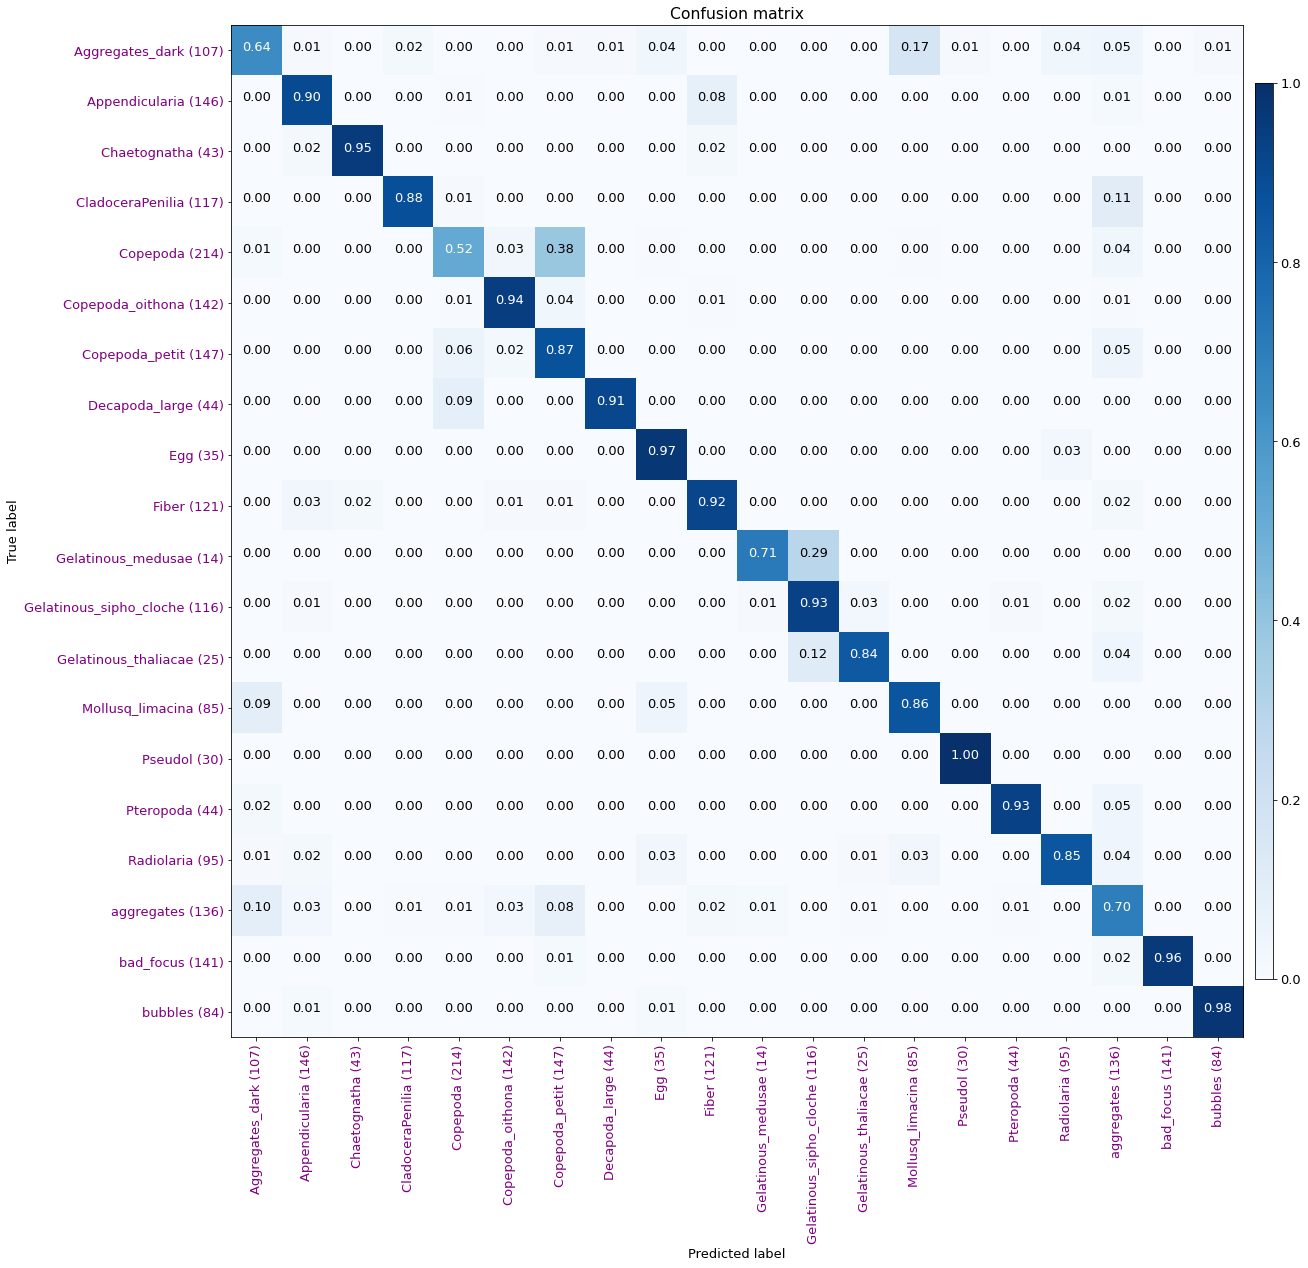

In [45]:
GMeanRecalls=[]
AverageAccuracies=[]
ClassBalanceAccuracies=[]

fold = 'man1'


model_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'

model = tf.keras.models.load_model(
                                    model_filename,
                                   compile=False
                                    )

test_iterator = validation_gen.flow_from_dataframe(
                                                    X_validation_df,
                                                    x_col = "filenames", y_col = "labels",
                                                    batch_size = 1,
                                                    target_size = IMG_SIZE, 
                                                    color_mode = COLOR_MODE,
                                                    class_mode = "categorical", shuffle = False
                                                       )


test_prob=model.predict(test_iterator)
test_pred = test_prob.argmax(axis=1).tolist()
test_true = test_iterator.classes

num_per_targetNames = Counter(test_iterator.classes)
print(num_per_targetNames)
targetNames=list(test_iterator.class_indices.keys())
print(targetNames)

# Accuracy, Precision, Recall, F1 score
print(classification_report(test_true, test_pred, target_names=targetNames), sep='')

REPORT_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-classification_report-test_set-fold_{fold}.csv'
df_classification_report = pd.DataFrame(classification_report(test_true, test_pred, target_names=targetNames, digits=2, output_dict=True)).transpose()
df_classification_report.to_csv(REPORT_filename)


# Confusion matrix
confusion_mtx = confusion_matrix(test_true, test_pred) 

confusionmatrix_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-confusion_matrix-test_set-fold_{fold}.png'
fig = plt.figure()
plt.rc('font', size=13)
fig.set_size_inches(20, 20, forward=True)
foo5.plot_confusion_matrix(confusion_mtx, classes = targetNames, num_images_per_class = num_per_targetNames, normalize=True) 
plt.savefig(confusionmatrix_filename,bbox_inches="tight")


#average accuracy
AverageAccuracies.append(accuracy_score(test_true,test_pred))

# geometric average of recall
GMeanRecalls.append(computeGeometricAverageOfRecall(test_true, test_pred))

# class balance accuracy
ClassBalanceAccuracies.append(calc_ClassBalancedAccuracy(confusion_mtx, list(test_iterator.class_indices.values()), targetNames))



In [46]:
display(GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies)

keys = ['man1']

vals = np.array([GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies])

score_dict = dict(zip(keys, zip(*vals)))

display(score_dict)

z = {'Evaluation_scores':("Geometric_Average_of_Recalls","Average_Accuracy", "Class_Balance_Accuracy"), **score_dict}

display(z)

display(pd.DataFrame.from_dict(z))

EVALUATION_SCORE_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-evaluation_score-test_sets.csv'
pd.DataFrame.from_dict(z).to_csv(EVALUATION_SCORE_filename, index=None)

[0.8538441608071379]

[0.8377518557794273]

[0.8212187619383622]

{'man1': (0.8538441608071379, 0.8377518557794273, 0.8212187619383622)}

{'Evaluation_scores': ('Geometric_Average_of_Recalls',
  'Average_Accuracy',
  'Class_Balance_Accuracy'),
 'man1': (0.8538441608071379, 0.8377518557794273, 0.8212187619383622)}

,Evaluation_scores,man1
0,Geometric_Average_of_Recalls,0.853844
1,Average_Accuracy,0.837752
2,Class_Balance_Accuracy,0.821219
